In [3]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns


In [ ]:
# Step 1: Load your dataset (replace with your actual file path)
df = pd.read_csv("dataset3.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'deduplicated_news2.csv'

In [ ]:
# Step 2: Drop NaN values and RESET INDEX to keep alignment
df = df.dropna(subset=['content']).reset_index(drop=True)  # Critical: reset_index
texts = df['content'].tolist()  # Now texts and df have identical length

In [ ]:
# Step 3: Generate embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(texts, show_progress_bar=True)

Batches: 100%|██████████| 150/150 [05:29<00:00,  2.20s/it]


In [ ]:
# Step 4: Cluster (lengths will match)
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(embeddings)
df['cluster'] = kmeans.labels_  # Works now!

In [ ]:
# Step 5: Visualize clusters using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)
df['x'] = reduced_embeddings[:, 0]
df['y'] = reduced_embeddings[:, 1]

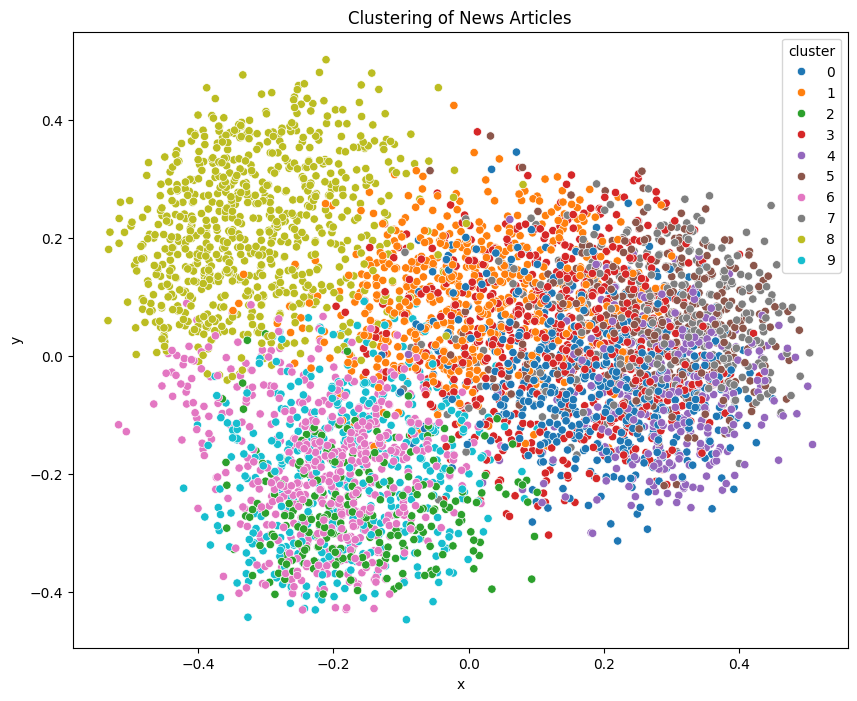

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='x', y='y', hue='cluster', palette='tab10')
plt.title("Clustering of News Articles")
plt.show()

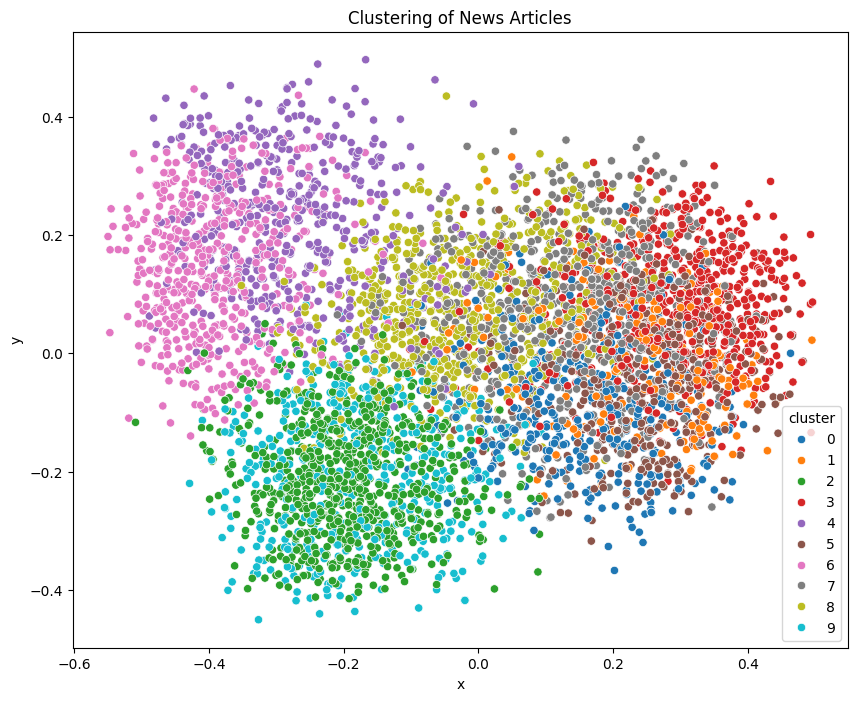

Found 2659 redundant article pairs
Deduplicated dataset saved to deduplicated_news.csv


In [ ]:

# Step 5: Visualize clusters using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)
df['x'] = reduced_embeddings[:, 0]
df['y'] = reduced_embeddings[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='x', y='y', hue='cluster', palette='tab10')
plt.title("Clustering of News Articles")
plt.show()

# Step 6 (optional): Find redundant articles
similarity_matrix = cosine_similarity(embeddings)
threshold = 0.9  # Articles above this are considered very similar
redundant_pairs = []

for i in range(len(similarity_matrix)):
    for j in range(i + 1, len(similarity_matrix)):
        if similarity_matrix[i][j] > threshold:
            redundant_pairs.append((i, j))

print(f"Found {len(redundant_pairs)} redundant article pairs")

# Optional: Filter redundant articles
unique_indices = set(range(len(texts)))
for i, j in redundant_pairs:
    if j in unique_indices:
        unique_indices.remove(j)

deduplicated_df = df.iloc[list(unique_indices)]
deduplicated_df.to_csv("deduplicated_news.csv", index=False)
print("Deduplicated dataset saved to deduplicated_news.csv")


In [ ]:
import numpy as np

# Compute similarity matrix
similarity_matrix = cosine_similarity(embeddings)
threshold = 0.9  # Similarity threshold for duplicates

# Find duplicates efficiently
duplicates = set()
for i in range(len(similarity_matrix)):
    if i not in duplicates:  # Skip already marked duplicates
        # Find all similar articles to this one
        similar_indices = np.where(similarity_matrix[i] > threshold)[0]
        # Keep the first one (i) and mark others as duplicates
        duplicates.update(similar_indices[similar_indices > i])  # Only keep one version

# Create deduplicated dataset
unique_indices = [i for i in range(len(df)) if i not in duplicates]
deduplicated_df = df.iloc[unique_indices].reset_index(drop=True)

# Save results
print(f"Original articles: {len(df)}")
print(f"Duplicate articles found: {len(duplicates)}")
print(f"Unique articles remaining: {len(deduplicated_df)}")
deduplicated_df.to_csv("deduplicated_news2.csv", index=False)

# Optional: Save list of duplicates
duplicate_df = df.iloc[list(duplicates)].reset_index(drop=True)
duplicate_df.to_csv("removed_duplicates1.csv", index=False)

Original articles: 5763
Duplicate articles found: 984
Unique articles remaining: 4779
